The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Sector: T70737B
AugmentationReport(total_slots=284, infeasible_lambda_slots=0, used_clamp_slots=0)
{'mae': 2.626090364725496, 'rmse': 3.5519382834826123, 'mape_%': 13.648088566057314}


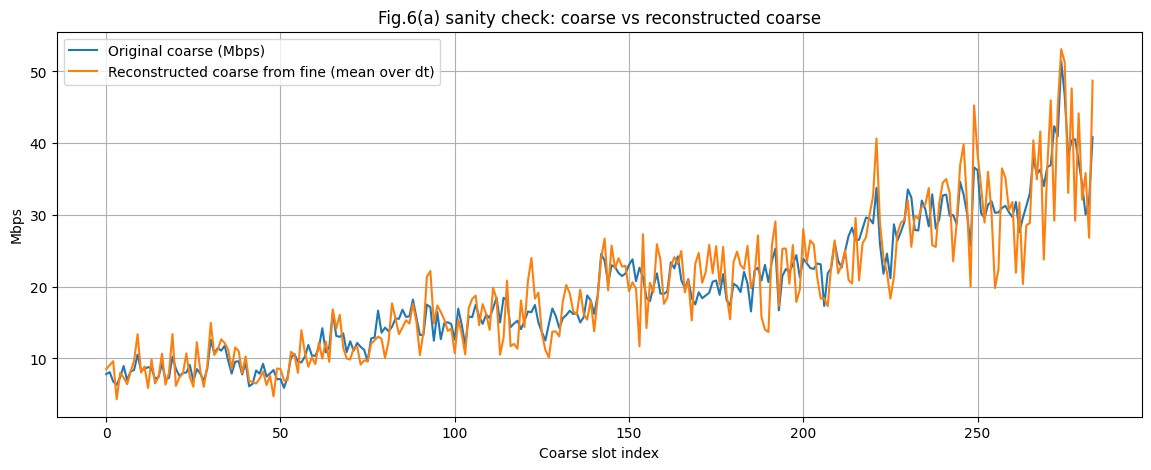

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt

from src.config import KTHParams
from src.utils import rolling_variance_proxy, summary_errors
from src.kth_ipp import generate_fine_series_from_coarse

df = pd.read_csv("data/histo_trafic.csv", sep=";", encoding="latin1")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

df["tstamp_clean"] = df["tstamp"].str.replace(r"^[a-zA-Zéûîôàç]+\s+", "", regex=True)

month_map = {"janvier":"January","février":"February","mars":"March","avril":"April","mai":"May","juin":"June",
             "juillet":"July","août":"August","septembre":"September","octobre":"October","novembre":"November","décembre":"December"}
for fr, en in month_map.items():
    df["tstamp_clean"] = df["tstamp_clean"].str.replace(fr, en, regex=False)

df["tstamp"] = pd.to_datetime(df["tstamp_clean"], format="%d %B %Y")
df = df.drop(columns="tstamp_clean")
df = df.sort_values(["secteur", "tstamp"])
df["trafic_mbps"] = pd.to_numeric(df["trafic_mbps"], errors="coerce")
df = df.dropna(subset=["trafic_mbps"])

# we choose ONE sector for the sanity plot
sector_id = df.groupby("secteur")["trafic_mbps"].mean().sort_values().index[len(df["secteur"].unique())//2]
df_s = df[df["secteur"] == sector_id].sort_values("tstamp")
coarse = df_s["trafic_mbps"].to_numpy()


p = KTHParams(
    T=300.0,
    tau = 1/15,
    zeta = 1/60,
    lambda_fixed = 1,
    dt = 5.0,
)



fine, report, recon = generate_fine_series_from_coarse(
    coarse,
    coarse_var_unused=None,   # not used anymore
    p=p,
    seed=42
)

print("Sector:", sector_id)
print(report)
print(summary_errors(coarse, recon))

plt.figure(figsize=(14,5))
plt.plot(coarse, label="Original coarse (Mbps)")
plt.plot(recon, label="Reconstructed coarse from fine (mean over dt)")
plt.title("Fig.6(a) sanity check: coarse vs reconstructed coarse")
plt.xlabel("Coarse slot index")
plt.ylabel("Mbps")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import numpy as np
import pandas as pd

def summarize_fine_vs_coarse(coarse, fine, T, dt):
    steps = int(round(T/dt))
    fine = fine.reshape(-1, steps)

    recon_mean = fine.mean(axis=1)
    recon_std  = fine.std(axis=1)

    eps = 1e-9
    mape_mean = np.mean(np.abs(recon_mean - coarse) / (np.abs(coarse) + eps))

    cv = np.median(recon_std / (recon_mean + eps))
    zero_frac = np.median((fine == 0).mean(axis=1))
    spike_ratio = np.median(fine.max(axis=1) / (recon_mean + eps))

    return {
        "mape_mean": float(mape_mean),
        "cv_med": float(cv),
        "zero_frac_med": float(zero_frac),
        "spike_ratio_med": float(spike_ratio),
    }

def score_metrics(m):
    # Hard constraint
    score = 50.0 * m["mape_mean"]

    # Soft targets (tweak as desired)
    # target ranges: CV in [0.7, 1.8], zero_frac in [0.15, 0.70], spike_ratio in [2, 8]
    def range_penalty(x, lo, hi):
        if x < lo: return (lo - x)
        if x > hi: return (x - hi)
        return 0.0

    score += 2.0 * range_penalty(m["cv_med"], 0.7, 1.8)
    score += 1.0 * range_penalty(m["zero_frac_med"], 0.15, 0.70)
    score += 0.5 * range_penalty(m["spike_ratio_med"], 2.0, 8.0)

    return float(score)

# --- pick some sectors ---
sector_means = df.groupby("secteur")["trafic_mbps"].mean().sort_values()
picked = [
    sector_means.index[int(0.1*len(sector_means))],
    sector_means.index[int(0.5*len(sector_means))],
    sector_means.index[int(0.9*len(sector_means))]
]

# candidate grid
taus  = [1/120, 1/60, 1/30, 1/15]      # OFF mean: 120s..15s
zetas = [1/60, 1/30, 1/15, 1/8]        # ON mean: 60s..8s
lams  = [0.1, 0.3, 0.5, 1.0, 2.0]      # arrivals/sec during ON

rows = []
for tau in taus:
    for zeta in zetas:
        for lam in lams:
            # build params
            p = KTHParams(T=300.0, dt=5.0, tau=tau, zeta=zeta, lambda_fixed=lam)

            metrics_list = []
            for sec in picked:
                df_s = df[df["secteur"] == sec].sort_values("tstamp")
                coarse = df_s["trafic_mbps"].to_numpy()

                fine, report, recon = generate_fine_series_from_coarse(
                    coarse, coarse_var_unused=None, p=p, seed=42
                )

                # metrics computed on fine-rate series
                m = summarize_fine_vs_coarse(coarse, fine, T=p.T, dt=p.dt)
                metrics_list.append(m)

            # aggregate metrics across chosen sectors
            agg = {k: float(np.median([m[k] for m in metrics_list])) for k in metrics_list[0].keys()}
            sc = score_metrics(agg)

            rows.append({
                "tau": tau, "zeta": zeta, "lambda_fixed": lam,
                **agg, "score": sc
            })

results = pd.DataFrame(rows).sort_values("score")
results.head(10)


,tau,zeta,lambda_fixed,mape_mean,cv_med,zero_frac_med,spike_ratio_med,score
64,0.066667,0.016667,2.0,0.126743,0.655029,0.133333,2.666896,6.443775
63,0.066667,0.016667,1.0,0.136225,0.825141,0.150000,3.424297,6.811275
62,0.066667,0.016667,0.5,0.153522,1.069602,0.216667,4.412695,7.676099
69,0.066667,0.033333,2.0,0.157796,0.827279,0.233333,3.054050,7.889812
68,0.066667,0.033333,1.0,0.164786,0.987357,0.266667,3.980762,8.239287
61,0.066667,0.016667,0.3,0.167774,1.319331,0.350000,5.687810,8.388724
74,0.066667,0.066667,2.0,0.177220,1.069947,0.383333,3.924293,8.860995
73,0.066667,0.066667,1.0,0.179602,1.251219,0.416667,5.014222,8.980109
67,0.066667,0.033333,0.5,0.182342,1.252150,0.333333,5.296732,9.117095
66,0.066667,0.033333,0.3,0.206180,1.500430,0.450000,6.606353,10.309013


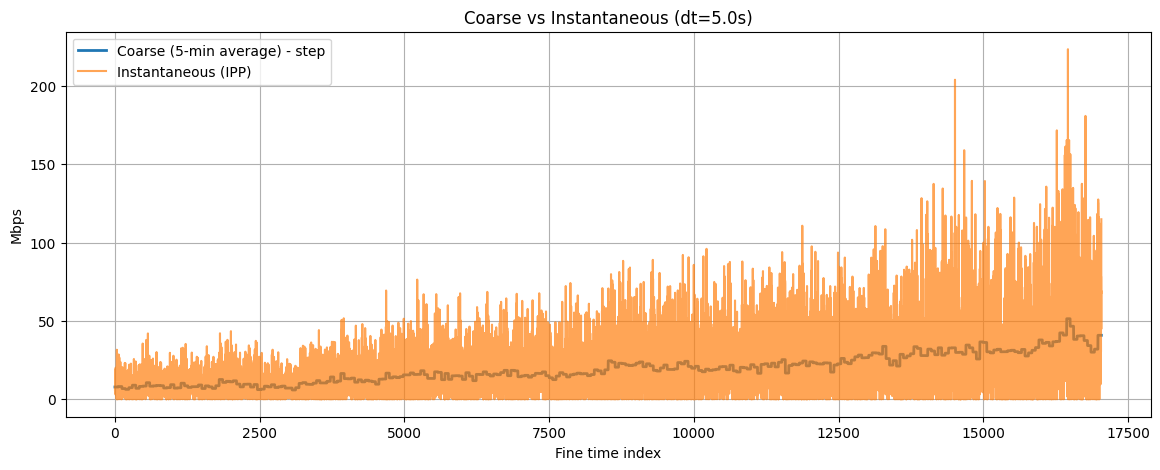

In [7]:
import numpy as np
# number of fine steps per coarse slot
steps = int(p.T / p.dt)

# Expand coarse into step function
coarse_step = np.repeat(coarse, steps)

# Fine signal already aligned
fine_series = fine[:len(coarse_step)]

plt.figure(figsize=(14,5))
plt.plot(coarse_step, label="Coarse (5-min average) - step", linewidth=2)
plt.plot(fine_series, label="Instantaneous (IPP)", alpha=0.7)

plt.title(f"Coarse vs Instantaneous (dt={p.dt}s)")
plt.xlabel("Fine time index")
plt.ylabel("Mbps")
plt.legend()
plt.grid(True)
plt.show()


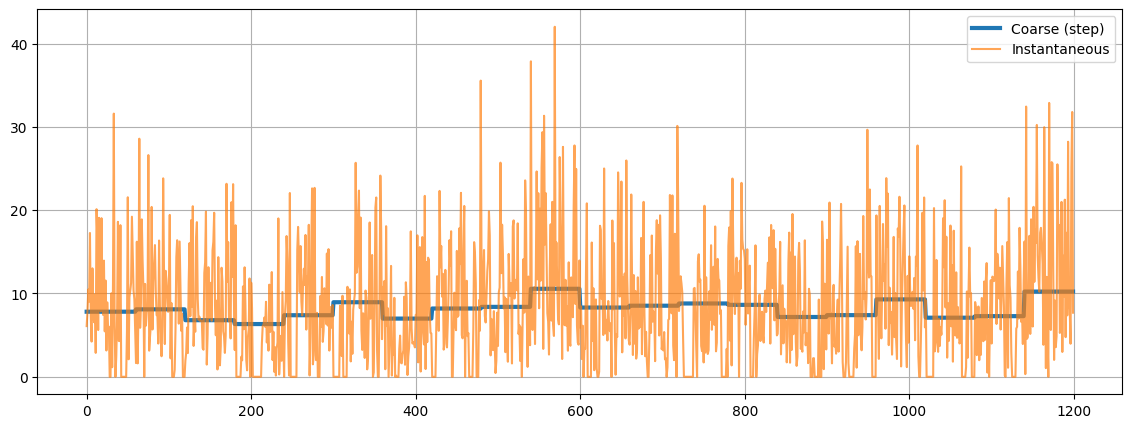

In [8]:
n_slots = 20
coarse_step = np.repeat(coarse[:n_slots], steps)
fine_part = fine[:n_slots*steps]

plt.figure(figsize=(14,5))
plt.plot(coarse_step, label="Coarse (step)", linewidth=3)
plt.plot(fine_part, label="Instantaneous", alpha=0.7)
plt.legend()
plt.grid(True)
plt.show()
